In [1]:
import numpy as np
import fnmatch
import xarray as xr
import os
from collections import defaultdict
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
from xmip.postprocessing import combine_datasets,_concat_sorted_time
from sklearn.decomposition import PCA
import xesmf as xe
import gcsfs
fs = gcsfs.GCSFileSystem() # equivalent to fsspec.fs('gs')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/tmp/ipykernel_3557/2499309971.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
grid_size = 9 #n by n degree grid around each TG
cmip6_resolution = 1.5

num_grid_cells = int(grid_size/cmip6_resolution)

mlr_coefs = xr.open_dataset('/home/jovyan/CMIP6cex/cmip6_processing/gssr_mlr_coefs_1p5_9deg_codec.nc') #load MLR coefficients at TGs
era5_pcs = xr.open_dataset('/home/jovyan/CMIP6cex/cmip6_processing/era5_pca_components_1p5_9deg.nc')

Loop over timeseries of `psl` & `sfcWind` at common 1.5 by 1.5 degree grid and open them:

In [3]:
#in_dir = '/home/jovyan/CMIP6cf/output/subsetted_forcing/'
var1 = 'psl'
var2 = 'sfcWind'

var1_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var1+'_europe'
var2_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var2+'_europe'

output_dir = 'leap-persistent/timh37/CMIP6/timeseries/surge_tgs'

var1_models = [k.split('/')[-1] for k in fs.ls(var1_dir) if k.startswith('.')==False]
var2_models = [k.split('/')[-1] for k in fs.ls(var2_dir) if k.startswith('.')==False]

models = [k for k in var1_models if k in var2_models]
ddict = defaultdict(dict)

for source_id in ['MRI-ESM2-0']:##models:
    var1_model_path = os.path.join(var1_dir,source_id)
    var2_model_path = os.path.join(var2_dir,source_id)
    
    var1_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var1_model_path) if s.startswith('.')==False] 
    var2_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var2_model_path) if s.startswith('.')==False]
    experiment_ids = list(set(var1_exps) & set(var2_exps))
    
    for experiment_id in ['ssp245']:#set(experiment_ids): #for each experiment_id, open the datasets, concatenating all realizations:
        #load data:
        fn = fnmatch.filter(fs.ls(var1_model_path),'*'+experiment_id+'*')[0]
        fn = fn.split('/')[-1]
        
        var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000,'longitude':5})
        
        ddict[fn.replace('.zarr','')] = var1_var2_data
        

In [4]:
ddict_predictors = defaultdict(dict)

for key,ds in tqdm(ddict.items()):
    for m,member in enumerate(ds.member_id.values):
        ds_mem = ds.sel(member_id=member)#.chunk({'time':5000,'longitude':1000,'latitude':1000})
        
        if key == list(ddict.keys())[0]: #common grid, so only need to generate these grids for the first ds
            lat_ranges = np.zeros((len(mlr_coefs.tg),int(grid_size/cmip6_resolution)))
            lon_ranges = np.zeros((len(mlr_coefs.tg),int(grid_size/cmip6_resolution)))

            for t,tg in enumerate(mlr_coefs.tg.values):
                lat_ranges[t,:] = ds_mem.latitude[((ds_mem.latitude>=(mlr_coefs.sel(tg=tg).lat-grid_size/2)) & (ds_mem.latitude<=(mlr_coefs.sel(tg=tg).lat+grid_size/2)))][0:int(grid_size/cmip6_resolution)]
                lon_ranges[t,:] = ds_mem.longitude[((ds_mem.longitude>=(mlr_coefs.sel(tg=tg).lon-grid_size/2)) & (ds_mem.longitude<=(mlr_coefs.sel(tg=tg).lon+grid_size/2)))][0:int(grid_size/cmip6_resolution)]
        
            lons_da = xr.DataArray(lon_ranges,dims=['tg','lon_around_tg'],coords={'tg':mlr_coefs.tg,'lon_around_tg':np.arange(0,int(grid_size/cmip6_resolution))})
            lats_da = xr.DataArray(lat_ranges,dims=['tg','lat_around_tg'],coords={'tg':mlr_coefs.tg,'lat_around_tg':np.arange(0,int(grid_size/cmip6_resolution))})
        
        

  0%|          | 0/1 [00:00<?, ?it/s]

Generate predictor data and multiply with regression coefficients:

In [10]:
ddict_predictors = defaultdict(dict)

for key,ds in tqdm(ddict.items()):
    for m,member in enumerate(ds.member_id.values):
        ds_mem = ds.sel(member_id=member)#.chunk({'time':5000,'longitude':1000,'latitude':1000})
        
        if key == list(ddict.keys())[0]: #common grid, so only need to generate these grids for the first ds
            lat_ranges = np.zeros((len(mlr_coefs.tg),int(grid_size/cmip6_resolution)))
            lon_ranges = np.zeros((len(mlr_coefs.tg),int(grid_size/cmip6_resolution)))

            for t,tg in enumerate(mlr_coefs.tg.values):
                lat_ranges[t,:] = ds_mem.latitude[((ds_mem.latitude>=(mlr_coefs.sel(tg=tg).lat-grid_size/2)) & (ds_mem.latitude<=(mlr_coefs.sel(tg=tg).lat+grid_size/2)))][0:int(grid_size/cmip6_resolution)]
                lon_ranges[t,:] = ds_mem.longitude[((ds_mem.longitude>=(mlr_coefs.sel(tg=tg).lon-grid_size/2)) & (ds_mem.longitude<=(mlr_coefs.sel(tg=tg).lon+grid_size/2)))][0:int(grid_size/cmip6_resolution)]
        
            lons_da = xr.DataArray(lon_ranges,dims=['tg','lon_around_tg'],coords={'tg':mlr_coefs.tg,'lon_around_tg':np.arange(0,int(grid_size/cmip6_resolution))})
            lats_da = xr.DataArray(lat_ranges,dims=['tg','lat_around_tg'],coords={'tg':mlr_coefs.tg,'lat_around_tg':np.arange(0,int(grid_size/cmip6_resolution))})
        
        
        #sanity check timeseries length
        num_days = (ds_mem.time[-1]-ds_mem.time[0]).dt.days
        assert (len(ds_mem.time) > .9*num_days) & (len(ds_mem.time) < 1.1*num_days)
        
        
        predictors = ds_mem
        
        #generate predictors
        predictors['sfcWind_sqd'] = predictors['sfcWind']**2 #add wind squared
        predictors['sfcWind_cbd'] = predictors['sfcWind']**3 #add wind cubed
        
        predictors = (predictors-predictors.mean(dim='time'))/predictors.std(dim='time',ddof=0) #normalize predictor variables (ignores nan by default?)
        predictors = predictors.sel(latitude=lats_da,longitude=lons_da).load() #takes a lot of memory, but is much more efficient than loading per TG?
        
        #concatenate & stack normalized forcing variables to data array with shape (time,(4 variables * grid_size * grid_size))
        predictors['predictors'] = predictors[["psl", "sfcWind", "sfcWind_sqd","sfcWind_cbd"]].to_array(dim="predictor_var") 
        predictors['predictors'] = predictors['predictors'].transpose("time","predictor_var","lon_around_tg",...).stack(f=['predictor_var','lon_around_tg','lat_around_tg'],create_index=False)
        
        #compute surges from predictors
        if m==0: #initialize
            surge_ds = xr.Dataset(data_vars=dict(surge=(['member_id','time','tg'], np.nan*np.zeros( (len(ds.member_id),len(ds.time),len(mlr_coefs.tg))) )),
                            coords=dict(member_id=ds.member_id,time=ds.time,tg=mlr_coefs.tg)) #initialize output dataset per model
        
        for t,tg in enumerate(['le_conquet_.csv']):#mlr_coefs.tg):
            predictors_at_tg = predictors.sel(tg=tg)
            mlr_coefs_at_tg = mlr_coefs.mlr_coefs.sel(tg=tg)
            
            num_pcs = int(np.sum(np.isfinite(mlr_coefs_at_tg)))-1 #number of mlr coefs = number of PCs to derive, intercept doesn't count
            idx_timesteps_w_data = np.argwhere((np.isfinite(predictors_at_tg.predictors).all(axis=1)).values).flatten() #omit timesteps with NaN if any
            
            #get principal components (using sklearn to keep deterministic signs consistent)
            pca = PCA(num_pcs)
            pca.fit(predictors_at_tg.predictors.isel(time=idx_timesteps_w_data)) #remove missing values for PCA
            pcs = pca.transform(predictors_at_tg.predictors.isel(time=idx_timesteps_w_data))
            
            components = xr.DataArray(data=pca.components_,dims=['pc','f'],coords=dict(pc=np.arange(num_pcs),f=predictors_at_tg.f))
            
            #compute RMSEs with ERA5 principal components, only considering the pressure part of the forcing (first num_grid_cells**2)
            rmses = np.sqrt(((components.isel(f=np.arange(num_grid_cells**2))-era5_pcs.sel(tg=tg).isel(f=np.arange(num_grid_cells**2)).isel(pc=np.arange(num_pcs)).component)**2).mean(dim='f')) #original sign
            rmses_flipped = np.sqrt(((components.isel(f=np.arange(num_grid_cells**2))--era5_pcs.isel(f=np.arange(num_grid_cells**2)).sel(tg=tg).isel(pc=np.arange(num_pcs)).component)**2).mean(dim='f')) #opposite sign
            
            s = (rmses<rmses_flipped).astype('int') #flip pcs if rmse of flipped pc is lower
            s[s==0]=-1
            pcs = pcs * s.values
            
            #multiply with ERA5 regression coefficients to compute surges
            surge_ds['surge'][m,idx_timesteps_w_data,t] = np.sum(mlr_coefs_at_tg[np.isfinite(mlr_coefs_at_tg)].values * np.column_stack((np.ones(pcs.shape[0]),pcs)),axis=1) 
        
    #surge_ds.to_zarr(os.path.join('gs://',output_dir,ds.source_id,key+'.zarr'),mode='w')
    #surge_ds.to_zarr(os.path.join('gs://',output_dir,'MPI-ESM1-2-HR_CanESM5_grid',key+'.zarr'),mode='w')
    #surge_ds.close()

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
test=predictors.transpose("time","predictor_var","lon_around_tg",...).stack(f=['predictor_var','lon_around_tg','lat_around_tg'],create_index=True)

In [7]:
test['pcs'] = (('pc','f'),pca.components_)

In [8]:
unstacked = test.unstack()

In [9]:
np.sum(pca.explained_variance_ratio_[0:15])

0.9658379936025995

In [13]:
components * s

<xarray.DataArray (pc: 10, f: 144)>
array([[-0.08175699, -0.08020663, -0.07639218, ...,  0.08729715,
         0.08602677,  0.07395228],
       [-0.08080209, -0.09787835, -0.1137751 , ..., -0.01253616,
         0.01935456,  0.03851721],
       [ 0.1087653 ,  0.10473869,  0.10021665, ...,  0.06023058,
         0.11475888,  0.12735946],
       ...,
       [ 0.19647245,  0.12151656,  0.03367341, ...,  0.00491201,
        -0.02050075, -0.02614704],
       [ 0.12813017,  0.11773662,  0.10642895, ..., -0.22332892,
        -0.14535524,  0.01785037],
       [ 0.00949892,  0.01904197,  0.02815846, ..., -0.01644648,
        -0.08844351, -0.04226165]])
Coordinates:
  * pc       (pc) int64 0 1 2 3 4 5 6 7 8 9
  * f        (f) int64 0 1 2 3 4 5 6 7 8 ... 135 136 137 138 139 140 141 142 143
    tg       <U15 'le_conquet_.csv'

Text(0.5, 1.0, '')

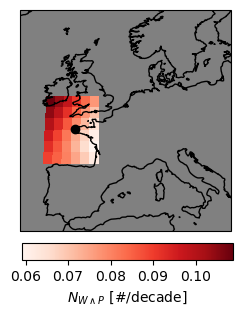

In [16]:
fig=plt.figure(figsize=(6,7.25)) #generate figure  
gs = fig.add_gridspec(2,2)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.pcolor(unstacked.longitude.isel(predictor_var=1).sel(tg='le_conquet_.csv'),unstacked.latitude.isel(predictor_var=1).sel(tg='le_conquet_.csv'),unstacked.pcs.isel(pc=2,predictor_var=0)*s[2],transform=ccrs.PlateCarree(),cmap='Reds')
ax.scatter(mlr_coefs.sel(tg='le_conquet_.csv').lon, mlr_coefs.sel(tg='le_conquet_.csv').lat,color='k',transform=ccrs.PlateCarree())       
             
#(n_wp_ds.lon,n_wp_ds.lat,c=(.25*n_wp_ds_present.mean(dim='member_id').mean(dim='source_id'))-num_extremes_mlr_eval.num_cooc_sfcWind,cmap='seismic',vmin=-30,vmax=30,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 20, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')
ax.set_title('')

In [66]:
bla = xr.open_dataset('/home/jovyan/CMIP6cex/cmip6_processing/gssr_mlr_coefs_1p5_6deg_codec.nc')

In [69]:
np.isfinite(bla.mlr_coefs).sum(dim='coef').mean()

<xarray.DataArray 'mlr_coefs' ()>
array(9.50806452)

In [70]:
np.isfinite(mlr_coefs.mlr_coefs).sum(dim='coef').mean()

<xarray.DataArray 'mlr_coefs' ()>
array(15.55645161)